In [1]:
!pip install pandas requests lxml html5lib beautifulsoup4 matplotlib seaborn numpy nba_api

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import json
from bs4 import BeautifulSoup
from scipy import stats
from nba_api.stats.endpoints import PlayerGameLogs
from nba_api.stats.endpoints import TeamGameLogs, PlayerGameLogs
from nba_api.stats.static import players, teams

In [3]:
players_list = players.get_players()
player_names = ["Damian Lillard", "Giannis Antetokounmpo", "Brook Lopez"]
player_ids = {
    player['full_name']: player['id']
    for player in players_list if player['full_name'] in player_names
}


mb_stats_2024_25_url = 'https://www.espn.com/nba/team/stats/_/name/mil/milwaukee-bucks'

nba_standings_2024_25 = "https://www.espn.com/nba/standings"

nba_standings_2024_25_league = "https://www.espn.com/nba/standings/_/group/league"

nba_standings_2023_24_league = "https://www.espn.com/nba/standings/_/season/2024/group/league"

extra_data_milwaukee_bucks = "https://www.espn.com.br/nba/time/estatisticas/_/nome/mil/table/game/ordenar/gamesPlayed/dir/desce"

nba_team_rooster = "https://www.nba.com/stats/team/1610612749"
espn_team_rooster = "https://www.espn.com/nba/team/roster/_/name/mil/milwaukee-bucks"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
}

headers_nba = {
    "Host": "stats.nba.com",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64; rv:134.0) Gecko/20100101 Firefox/134.0",
    "Accept": "*/*",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br, zstd",
    "Referer": "https://www.nba.com/",
    "Origin": "https://www.nba.com",
    "DNT": "1",
    "Connection": "keep-alive",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site",
    "Priority": "u=4"
  }

def read_html_with_requests(file_url):
    response = requests.get(file_url, headers=headers)
    df = pd.read_html(response.content)
    return df

def clean_team_name(name):
    name = name.split("--")[1] if '--' in name else name
    name = name.lstrip('0123456789') if any(name.startswith(str(i)) for i in range(1, 11)) else name
    return name

def split_name_number(name):
    match = re.search(r'(\D+)(\d+)?$', name)
    if match:
        return match.group(1).strip(), match.group(2) if match.group(2) else None
    return name, None



In [4]:
def read_request_from_nba_json(url, resultSets=-1):
  response = requests.get(url, headers=headers_nba)
  data_bytes = response.content
  data = json.loads(data_bytes.decode('utf-8'))
  data = data["resultSets"]
  roster = data[resultSets] if resultSets == -1 else data[resultSets]
  df = pd.DataFrame(roster["rowSet"], columns=roster["headers"])
  return df

def format_team_roster_nba():
  df = read_request_from_nba_json("https://stats.nba.com/stats/commonteamroster?LeagueID=00&Season=2024-25&TeamID=1610612749", 0)
  df = df.rename(columns={
        'PLAYER': 'Name'
    })
  df["AGE"] = df["AGE"].apply(lambda x: int(x))
  return df

def format_team_rooster_espn():
  df = read_html_with_requests(espn_team_rooster)
  df = df[0]
  df.drop(columns=[df.columns[0]], inplace=True)
  df['Name'] = df['Name'].apply(clean_team_name)
  df["Age"] = df["Age"].apply(lambda x: int(x))
  df[["Name", "NUM"]] = df["Name"].apply(lambda x: pd.Series(split_name_number(x)))
  return df

def format_total_carrer_data_by_player_id(id):
    return read_request_from_nba_json(f"https://stats.nba.com/stats/playercareerstats?LeagueID=00&PerMode=Totals&PlayerID={id}", 1)

def format_total_season_data_by_player_id(id, seasonIndex):
    return read_request_from_nba_json(f"https://stats.nba.com/stats/playercareerstats?LeagueID=00&PerMode=Totals&PlayerID={id}", 0)

def format_season_carrer_and_current_season_data_by_player_id(id):
    headers = ["GP", "PTS", "AST", "REB", "MIN"]
    carrer = format_total_carrer_data_by_player_id(id)[headers]
    carrer[headers[1:]] = carrer.apply(
        lambda row: row[1:] / row["GP"], axis=1
    )
    carrer["STATS"] = "Carreira"
    current_season = format_total_season_data_by_player_id("1631260", -1).iloc[[-1]][headers]
    current_season[headers[1:]] = current_season.apply(
        lambda row: row[1:] / row["GP"], axis=1
    )
    current_season["STATS"] = "Temporada Atual"
    final_df = pd.concat([current_season, carrer])[["STATS", "GP", "PTS", "AST", "REB", "MIN"]]
    return final_df

def get_game_logs_by_player_id_and_season(player_id, season):
    url = f"https://stats.nba.com/stats/playergamelogs?Season={season}&PlayerID={player_id}"
    return pd.DataFrame(read_request_from_nba_json(url))


In [5]:
def rf1():
  nba = format_team_roster_nba()
  espn = format_team_rooster_espn()
  print(nba)
  print(espn)
  df_merged = pd.merge(nba, espn[["Name", "Salary"]], on=["Name"], how="outer")
  df_merged["EXP"] = df_merged["EXP"].apply(lambda x: x if x != "R" else 0)
  df_merged.rename(columns={
        "PLAYER_ID": "ID",
        'Name':'Nome',
        "HEIGHT":"Altura",
        "WEIGHT":"Peso",
        "AGE":"Idade",
        "EXP":"Experiência",
        "POSITION": "Posição",
        "SCHOOL": "Universidade",
        "Salary": "Salário"
    }, inplace=True)
  return df_merged[["ID","Nome", "Altura", "Peso", "Idade", "Experiência", "Posição", "Universidade", "Salário"]]

In [6]:
#rf2
def format_team_schedule():
  response = requests.get("https://www.nba.com/team/1610612749/schedule", headers=headers)
  data_bytes = response.content
  soup = BeautifulSoup(data_bytes, 'html.parser')
  table = soup.find('table', class_='Crom_table__p1iZz')
  hd = ['Game ID'] + [th.text.strip() for th in table.find('thead').find_all('th')]
  hd.pop(7)
  hd.pop(6)
  hd.pop(4)
  rows = []
  for tr in table.find('tbody').find_all('tr'):
      game_id = tr.get('data-game-id', 'N/A')
      cells = [game_id]
      tds = tr.find_all('td')
      status = tds[2].text.strip()
      if "ET" in status:
         break

      for i in range(len(tds)):
          if(i in [3,5,6]):
             continue
          if i == 1:
             cells.append(tds[i].find('a')['href'].replace("/team/", "").strip("/"))
          elif tds[i].find('img'):
            cells.append(tds[i].find('img')['title'])  # Extract broadcaster name
          elif tds[i].find('a'):
            cells.append(tds[i].find('a').text.strip())
          else:
           cells.append(tds[i].text.strip())
      rows.append(cells)

  df = pd.DataFrame(rows, columns=hd)
  return df

def get_data_by_nba_page(url):
   response = requests.get(url, headers=headers)
   soup = BeautifulSoup(response.text, "html.parser")
   script_tag = soup.find("script", {"id": "__NEXT_DATA__", "type": "application/json"})
   json_data = json.loads(script_tag.string)["props"]["pageProps"]
   json_data = json_data[list(json_data.keys())[1]]
   return json_data

def find_game_box_score_by_id(id):
    return get_data_by_nba_page(f"https://www.nba.com/game/{id}/box-score")

def find_players_score_game_by_team_id(game_id, team_id):
   game_score = find_game_box_score_by_id(game_id)
   is_home_team = game_score["homeTeamId"] == team_id
   players = game_score["homeTeam" if is_home_team else "awayTeam"]["players"]
   for i in range(len(players)):
      players[i]["Casa/Fora"] = "Casa" if is_home_team else "Fora"
      players[i] = players[i] | players[i]["statistics"]
      players[i]["Game ID"] = game_id

      del players[i]["statistics"]
   return pd.DataFrame(players)

def find_team_by_id(id):
   return get_data_by_nba_page(f"https://www.nba.com/team/{id}")

def format_team_name(id):
    team = find_team_by_id(id)["info"]
    return team["TEAM_CITY"] + " " + team["TEAM_NAME"]

def rf2(game_id = -1):
   team_roster = format_team_schedule()
   team_roster = team_roster[team_roster['Game ID'] == game_id] if game_id != -1 else team_roster
   all_data = []

   for _, row in team_roster.iterrows():
      game_data = find_players_score_game_by_team_id(row["Game ID"], 1610612749)
      game_data = game_data[game_data["personId"].isin(player_ids.values())]
      game_data["Game ID"] = row["Game ID"]
      row["Opponent"] = format_team_name(row["Opponent"])
      if row["Status"][0] == "W":
         game_data["V ou D"] = "V"
      elif row["Status"][0] == "L":
         game_data["V ou D"] = "D"
      else:
         game_data["V ou D"] = "E"
      row["Status"] = row["Status"][1:]
      game_data = game_data[["Game ID", "Casa/Fora", "points", "reboundsTotal", "assists", "minutes", "threePointersMade", "threePointersAttempted", "V ou D"]]
      for col in team_roster.columns:
         if col != "Game ID":
               game_data[col] = row[col]

      all_data.append(game_data)

   final_df = pd.concat(all_data, ignore_index=True)
   final_df.rename(columns={
    'Date': 'Data do Jogo',
    'Opponent': 'Adversário',
    'points': 'PTS',
    'reboundsTotal': 'REB',
    'assists': 'AST',
    'Status': 'Placar do Jogo',
    'threePointersAttempted': 'Tentativas de Cestas de 3 PTS',
    'threePointersMade': 'Cestas de 3 PTS Marcados',
    'minutes': 'Tempo de Permanência do Jogador em Quadra'}, inplace=True)
   return final_df[[
    'Game ID',
    'Data do Jogo',
    'Adversário',
    'V ou D',
    'Casa/Fora',
    'PTS',
    'REB',
    'AST',
    'Placar do Jogo',
    'Tentativas de Cestas de 3 PTS',
    'Cestas de 3 PTS Marcados',
    'Tempo de Permanência do Jogador em Quadra'
   ]]

In [7]:

#RF3

def get_players_minutes(player_ids, season="2024-25"):
    player_minutes = {}

    for name, player_id in player_ids.items():
        player_logs = PlayerGameLogs(
            player_id_nullable=player_id,
            season_nullable=season,
            season_type_nullable="Regular Season"
        ).get_data_frames()[0]

        # Pegando GAME_ID e MIN para associar ao jogo correto
        player_minutes[name] = player_logs[['GAME_ID', 'MIN']].rename(columns={'MIN': f'Tempo {name}'})

    # Convertendo os dicionários de DataFrame para um único DataFrame mesclado
    merged_minutes = None
    for df_minutes in player_minutes.values():
        if merged_minutes is None:
            merged_minutes = df_minutes
        else:
            merged_minutes = merged_minutes.merge(df_minutes, on="GAME_ID", how="outer")

    return merged_minutes

# Obtendo os minutos jogados
player_minutes_data = get_players_minutes(player_ids)

# Obtendo informações dos times


# Obtendo os jogos do Milwaukee Bucks (TEAM_ID: 1610612749)
game_data_pull = TeamGameLogs(
    league_id_nullable='00',  # NBA 00, G-League 20, WNBA 10
    team_id_nullable='1610612749',  # Milwaukee Bucks
    season_nullable='2024-25',
    season_type_nullable='Regular Season',  # Regular Season, Playoffs, Pre Season
    last_n_games_nullable = 300
)
df_season = game_data_pull.get_data_frames()[0]

def find_team_by_name_or_abbreviation(team_query):
    teams_info = teams.get_teams()
    all_teams_by_nba_api = pd.DataFrame(teams_info)[['id', 'abbreviation', 'full_name']]
    all_teams_by_nba_api.rename(columns={'id': 'TEAM_ID', 'abbreviation': 'ABBREVIATION', 'full_name': 'FULL_NAME'}, inplace=True)
    return all_teams_by_nba_api[
        (all_teams_by_nba_api['ABBREVIATION'].str.upper() == team_query.upper()) |
        (all_teams_by_nba_api['FULL_NAME'].str.upper() == team_query.upper())
    ]

# Filtrando jogos de um time específico
def apply_filter_on_team_games(df, team_query, game_date=None):
    # Buscar a sigla do time correspondente
    team_row = find_team_by_name_or_abbreviation(team_query)


    if team_row.empty:
        raise ValueError("Time não encontrado. Verifique a sigla ou nome completo.")

    team_abbr = team_row.iloc[0]['ABBREVIATION']  # Obtendo a sigla do time

    # Filtrando pelo adversário (usando a sigla correspondente)
    df_filtered = df[df['MATCHUP'].str.contains(f'vs. {team_abbr}|@ {team_abbr}', regex=True)]

    # Filtrando pela data do jogo, se fornecida
    if game_date:
        df_filtered = df_filtered[df_filtered['GAME_DATE'] == game_date]

    return df_filtered, team_row

# Transformação do DataFrame para formato RF3
def transform_to_table_3(df_filtered):
    df_filtered = df_filtered[[
        'GAME_DATE', 'MATCHUP', 'WL', 'PTS', 'REB', 'AST', 'GAME_ID', 'FG3A', 'FG3M', 'MIN', 'PLUS_MINUS'
    ]].rename(columns={
        'GAME_DATE': 'Data do Jogo',
        'MATCHUP': 'Adversário',
        'WL': 'V ou D',
        'PTS': 'PTS',
        'REB': 'REB',
        'AST': 'AST',
        'GAME_ID': 'GAME_ID',
        'FG3A': 'Tentativas de 3 PTS',
        'FG3M': 'Cestas de 3 PTS Marcados',
        'MIN': 'Tempo Total do Time',
        'PLUS_MINUS': 'Saldo de Pontos'
    })

    # Ajustando a coluna 'Adversário' para mostrar apenas o time oponente e se foi em casa/fora
    df_filtered['Casa/Fora'] = df_filtered['Adversário'].apply(lambda x: 'Casa' if 'vs.' in x else 'Fora')

    # Criando a coluna de Placar Real (PTS do time + PLUS_MINUS do adversário)
    df_filtered['Placar do Jogo'] = df_filtered.apply(lambda row: f"{row['PTS']} - {row['PTS'] - row['Saldo de Pontos']}", axis=1)

    # Fazendo merge com os minutos dos jogadores pelo GAME_ID
    df_filtered = df_filtered.merge(player_minutes_data, on="GAME_ID", how="left")

    # Removendo colunas desnecessárias
    df_filtered.drop(columns=["GAME_ID", "Saldo de Pontos"], inplace=True)

    return df_filtered



def rf_3_pt2():
    nome = input("Insira o nome do time: ")
    df_filtered, team = apply_filter_on_team_games(df_season, nome)
    return transform_to_table_3(df_filtered), team

def table_3():
    return transform_to_table_3(df_season)

def rf3():
    rf3_p2, _ = rf_3_pt2()
    return rf3_p2

In [8]:
#RF4
def count_home_away_games(df):
    home_games = df[df['Casa/Fora'] == 'Casa'].shape[0]
    away_games = df[df['Casa/Fora'] == 'Fora'].shape[0]
    return home_games, away_games


def rf4():
    df_table_3 = table_3()
    home_games, away_games = count_home_away_games(df_table_3)
    rf3_pt2, team =  rf_3_pt2()
    team_name = team["FULL_NAME"].iloc[0]
    home_games_against_team, away_games_against_team = count_home_away_games(rf3_pt2)
    data = {
        "Total Games": home_games + away_games,
        "Total Home Games": home_games,
        "Total Away Games": away_games,
        f"Home Games vs {team_name}": home_games_against_team,
        f"Away Games vs {team_name}": away_games_against_team
    }
    return pd.DataFrame([data])

In [9]:
#RF5
# Função para obter médias de carreira dos jogadores
def get_career_averages(player_ids):
    player_career_averages = {}
    headers = ["GP", "PTS", "AST", "REB", "MIN"]
    for name, player_id in player_ids.items():
        career_totals = format_total_carrer_data_by_player_id(player_id)
        career_totals = career_totals[headers]

        if not career_totals.empty:
            gp = career_totals['GP'].values[0]

            player_career_averages[name] = {
                'PTS': career_totals['PTS'].values[0] / gp,
                'REB': career_totals['REB'].values[0] / gp,
                'AST': career_totals['AST'].values[0] / gp
            }
        else:
            player_career_averages[name] = {'PTS': 0, 'REB': 0, 'AST': 0}
    return player_career_averages

# Função para calcular médias dos jogadores na temporada atual
def calculate_player_averages(player_ids):
    player_averages = {}
    headers = ["GP", "PTS", "AST", "REB", "MIN"]
    for name, player_id in player_ids.items():
        player_logs = format_total_season_data_by_player_id(player_id, -1).iloc[[-1]][headers]
        if player_logs.empty:
            continue
        gp = player_logs['GP'].values[0]
        player_averages[name] = {
            'PTS': player_logs['PTS'].values[0] / gp,
            'REB': player_logs['REB'].values[0] / gp,
            'AST': player_logs['AST'].values[0] / gp
        }

    return player_averages


# Função para calcular a porcentagem de jogos abaixo da média da carreira
def calculate_below_values_percentage(player_ids, player_averages):
    below_avg_percentages = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        p_logs = get_game_logs_by_player_id_and_season(player_id, "2024-25")[headers]

        if p_logs.empty:
            continue

        avg = player_averages[name]
        qtd_games = p_logs.shape[0]

        below_avg = {
            'PTS': (p_logs[p_logs['PTS'] < avg['PTS']].shape[0]) / qtd_games * 100,
            'REB': (p_logs[p_logs['REB'] < avg['REB']].shape[0]) / qtd_games * 100,
            'AST': (p_logs[p_logs['AST'] < avg['AST']].shape[0]) / qtd_games * 100
        }
        below_avg_percentages[name] = below_avg

    return below_avg_percentages

def rf5():
    player_career_averages = get_career_averages(player_ids)
    player_season_averages = calculate_player_averages(player_ids)
    below_career_avg_percentages = calculate_below_values_percentage(player_ids, player_career_averages)
    below_season_avg_percentages = calculate_below_values_percentage(player_ids, player_season_averages)
    data = [
        {
            "Player": player,
            "Season_Avg_PTS": player_season_averages[player]['PTS'],
            "Season_Avg_REB": player_season_averages[player]['REB'],
            "Season_Avg_AST": player_season_averages[player]['AST'],
            "Career_Avg_PTS": player_career_averages[player]['PTS'],
            "Career_Avg_REB": player_career_averages[player]['REB'],
            "Career_Avg_AST": player_career_averages[player]['AST'],
            "Below_Career_Avg_PTS": f"{below_career_avg_percentages[player]['PTS']:.2f}%",
            "Below_Career_Avg_REB": f"{below_career_avg_percentages[player]['REB']:.2f}%",
            "Below_Career_Avg_AST": f"{below_career_avg_percentages[player]['AST']:.2f}%",
            "Below_Season_Avg_PTS": f"{below_season_avg_percentages[player]['PTS']:.2f}%",
            "Below_Season_Avg_REB": f"{below_season_avg_percentages[player]['REB']:.2f}%",
            "Below_Season_Avg_AST": f"{below_season_avg_percentages[player]['AST']:.2f}%"
        }
        for player in player_ids.keys()
    ]
    return pd.DataFrame(data)


In [10]:
#RF6

from nba_api.stats.endpoints import PlayerGameLogs

# Função para calcular a mediana dos jogadores na temporada atual
def calculate_player_median(player_ids):
    player_medians = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        player_logs = get_game_logs_by_player_id_and_season(player_id, "2024-25")[headers]

        if player_logs.empty:
            continue

        player_medians[name] = {
            'PTS': np.median(player_logs['PTS']),
            'REB': np.median(player_logs['REB']),
            'AST': np.median(player_logs['AST'])
        }

    return player_medians

# Função para calcular a porcentagem de jogos abaixo da mediana
def calculate_below_median_percentage(player_ids, player_medians):
    below_median_percentages = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        player_logs = get_game_logs_by_player_id_and_season(player_id, "2024-25")[headers]

        if player_logs.empty:
            continue

        median_values = player_medians[name]

        below_median = {
            'PTS': np.mean(player_logs['PTS'] < median_values['PTS']) * 100,
            'REB': np.mean(player_logs['REB'] < median_values['REB']) * 100,
            'AST': np.mean(player_logs['AST'] < median_values['AST']) * 100
        }

        below_median_percentages[name] = below_median

    return below_median_percentages

def rf6():
    player_medians = calculate_player_median(player_ids)
    below_median_percentages = calculate_below_median_percentage(player_ids, player_medians)

    data = [
    {
        "Player": player,
        "Median_PTS": player_medians[player]['PTS'],
        "Median_REB": player_medians[player]['REB'],
        "Median_AST": player_medians[player]['AST'],
        "Below_Median_PTS": f"{below_median_percentages[player]['PTS']:.2f}%",
        "Below_Median_REB": f"{below_median_percentages[player]['REB']:.2f}%",
        "Below_Median_AST": f"{below_median_percentages[player]['AST']:.2f}%"
    }
    for player in player_ids.keys()
    ]

    return pd.DataFrame(data)


In [11]:
#RF7

def calculate_player_mode(player_ids):
    player_modes = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        player_logs = get_game_logs_by_player_id_and_season(player_id, "2024-25")[headers]
        if player_logs.empty:
            continue

        # Calculando moda e frequência correta
        mode_pts, count_pts = stats.mode(player_logs['PTS'], keepdims=True)
        mode_reb, count_reb = stats.mode(player_logs['REB'], keepdims=True)
        mode_ast, count_ast = stats.mode(player_logs['AST'], keepdims=True)

        player_modes[name] = {
            'PTS': (mode_pts[0], count_pts[0]),
            'REB': (mode_reb[0], count_reb[0]),
            'AST': (mode_ast[0], count_ast[0])
        }

    return player_modes

# Função para calcular a porcentagem abaixo da média
def calculate_below_avg_percentage(player_ids):
    below_avg_percentages = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        player_logs = get_game_logs_by_player_id_and_season(player_id, "2024-25")[headers]

        if player_logs.empty:
            continue

        avg_pts = player_logs['PTS'].mean()
        avg_reb = player_logs['REB'].mean()
        avg_ast = player_logs['AST'].mean()

        below_avg = {
            'PTS': (player_logs['PTS'] < avg_pts).mean() * 100,
            'REB': (player_logs['REB'] < avg_reb).mean() * 100,
            'AST': (player_logs['AST'] < avg_ast).mean() * 100
        }

        below_avg_percentages[name] = below_avg

    return below_avg_percentages
def rf7():
    player_modes = calculate_player_mode(player_ids)
    below_avg_percentages = calculate_below_avg_percentage(player_ids)
    data_stats = []
    for player in player_ids.keys():
        mode_pts, count_pts = player_modes[player]['PTS']
        mode_reb, count_reb = player_modes[player]['REB']
        mode_ast, count_ast = player_modes[player]['AST']

        data_stats.append({
            "Player": player,
            "Mode_PTS": mode_pts,
            "Count_PTS": count_pts,
            "Mode_REB": mode_reb,
            "Count_REB": count_reb,
            "Mode_AST": mode_ast,
            "Count_AST": count_ast,
            "Below_Avg_PTS": below_avg_percentages[player]['PTS'],
            "Below_Avg_REB": below_avg_percentages[player]['REB'],
            "Below_Avg_AST": below_avg_percentages[player]['AST']
        })
    return pd.DataFrame(data_stats)


In [12]:
#RF8
from scipy.stats import zscore

def remove_outliers(player_logs):
    z_scores = np.abs(zscore(player_logs[['PTS', 'REB', 'AST']]))
    return player_logs[(z_scores < 2).all(axis=1)]  # Mantém valores dentro de 2 desvios padrão

def calculate_std_without_outliers(player_ids, season="2024-25"):
    player_std_dev = {}

    for name, player_id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        player_logs = get_game_logs_by_player_id_and_season(player_id, season)[headers]

        if player_logs.empty:
            continue

        player_logs = remove_outliers(player_logs)

        player_std_dev[name] = {
            'PTS': np.std(player_logs['PTS'], ddof=1),
            'REB': np.std(player_logs['REB'], ddof=1),
            'AST': np.std(player_logs['AST'], ddof=1)
        }

    return player_std_dev

def rf8():
    player_standard_deviation_filtered = calculate_std_without_outliers(player_ids)
    data = [
        {
            "Player": player,
            "Dev_PTS": stats["PTS"],
            "Dev_REB": stats["REB"],
            "Dev_AST": stats["AST"]
        }
        for player, stats in player_standard_deviation_filtered.items()
    ]
    return pd.DataFrame(data)


In [13]:
def format_players_all_seasons_carrer(player_id, indexRS):
    url = f"https://stats.nba.com/stats/playerdashboardbyyearoveryearcombined?DateFrom=&DateTo=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID={player_id}&PlusMinus=N&Rank=N&Season=2024-25&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&VsConference=&VsDivision="
    players_carrer = read_request_from_nba_json(url, indexRS)
    players_carrer[["PLAYER_ID"]] = player_id
    players_carrer["TEAM"] = players_carrer["TEAM_ID"].apply(lambda x: format_team_name(x) if x != -1 else "-")

    return players_carrer

def rf9():
    team_roster = format_team_roster_nba()[["PLAYER_ID", "Name"]]
    team_roster = team_roster[team_roster["PLAYER_ID"].isin(player_ids.values())]
    team_roster[[]]
    all_data = []
    for _, row in team_roster.iterrows():
        player_data = format_total_carrer_data_by_player_id(row["PLAYER_ID"])[["PLAYER_ID","PTS", "AST", "REB"]]

        player_data["ID"] = row["PLAYER_ID"]
        player_data["Name"] = row["Name"]
        all_data.append(player_data)
    final_df = pd.concat(all_data, ignore_index=True)
    return final_df[["ID", "Name", "PTS","AST","REB"]]

In [14]:
#rf10
def rf10():
    all_data = []
    for name, id in player_ids.items():
        df = format_season_carrer_and_current_season_data_by_player_id(id)
        df = df.rename(columns={
          "GP": "Total de Jogos",
          "PTS": "Média de Pontos",
          "AST": "Média de Assistências",
          "REB": "Média de Rebotes",
          "MIN": "Minutos em Quadra"
          })
        df[["Nome"]] = name
        all_data.append(df)
    return pd.concat(all_data)


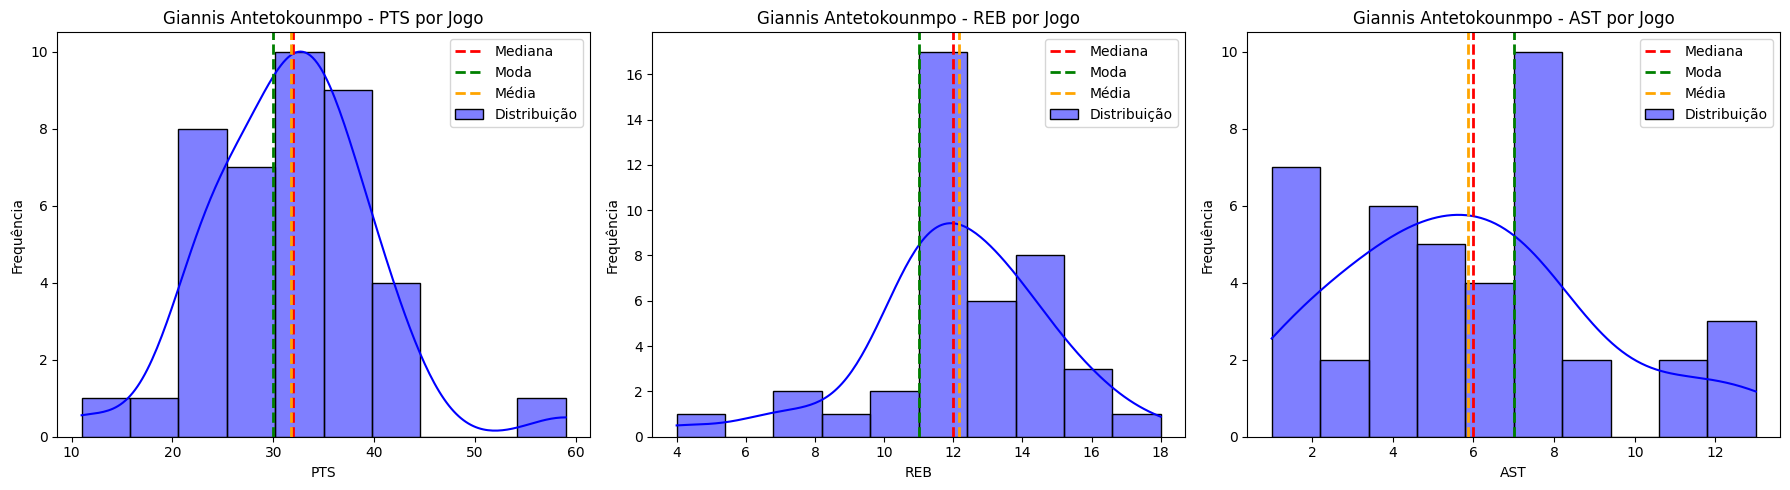

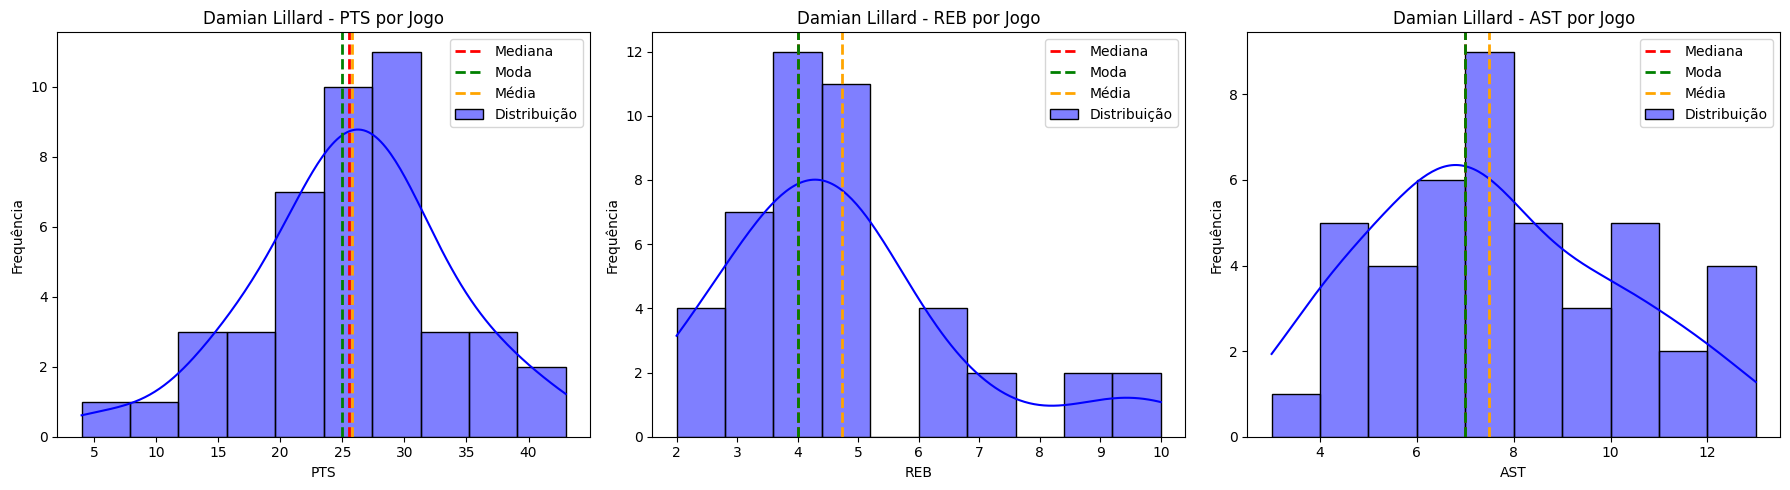

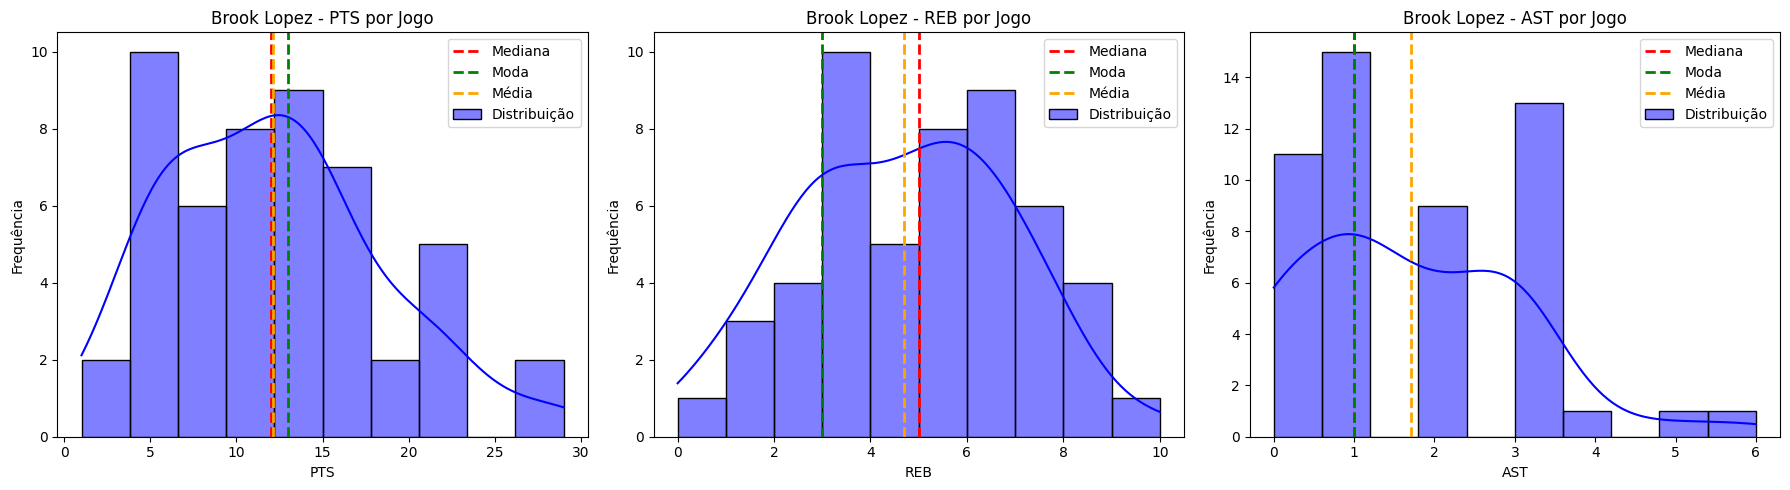

/tmp/ipykernel_284/2983636074.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Estatística", y="Valor", data=df_melted, palette="pastel")


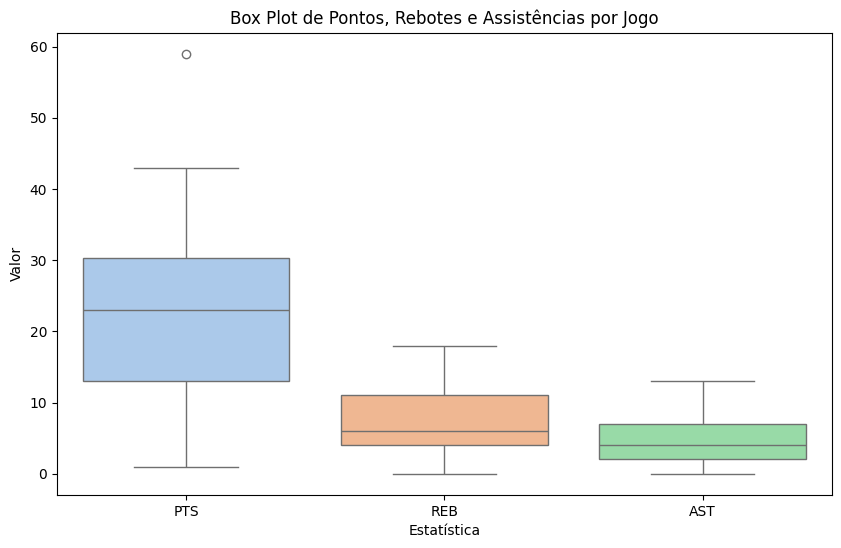

In [15]:
def rf11():
    player_avg = calculate_player_averages(player_ids)
    player_median = calculate_player_median(player_ids)
    player_modes = calculate_player_mode(player_ids)
    data_stats = []
    for player, id in player_ids.items():
        headers = ["PTS", "AST", "REB"]
        game_logs = get_game_logs_by_player_id_and_season(id, "2024-25")[headers]
        mode_pts, count_pts = player_modes[player]['PTS']
        mode_reb, count_reb = player_modes[player]['REB']
        mode_ast, count_ast = player_modes[player]['AST']

        median_pts = player_median[player]['PTS']
        median_reb = player_median[player]['REB']
        median_ast = player_median[player]['AST']

        avg_pts = player_avg[player]['PTS']
        avg_reb = player_avg[player]['REB']
        avg_ast = player_avg[player]['AST']

        data_stats.append({
            "Player": player,
            "Mode_PTS": mode_pts,
            "Count_PTS": count_pts,
            "Mode_REB": mode_reb,
            "Count_REB": count_reb,
            "Mode_AST": mode_ast,
            "Count_AST": count_ast,
            "Median_PTS": median_pts,
            "Median_REB": median_reb,
            "Median_AST": median_ast,
            "Avg_PTS": avg_pts,
            "Avg_REB": avg_reb,
            "Avg_AST": avg_ast,
            "List_Games": game_logs

        })
    return pd.DataFrame(data_stats)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_player_stats(df):
    for _, row in df.iterrows():
        player = row["Player"]
        game_logs = row["List_Games"]

        if not isinstance(game_logs, pd.DataFrame):
            print(f"Erro: Dados de {player} não são um DataFrame.")
            continue

        stats = ["PTS", "REB", "AST"]
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for i, stat in enumerate(stats):
            sns.histplot(game_logs[stat], bins=10, kde=True, ax=axes[i], label="Distribuição", color="blue")
            axes[i].axvline(row[f"Median_{stat}"], color="red", linestyle="dashed", linewidth=2, label="Mediana")
            axes[i].axvline(row[f"Mode_{stat}"], color="green", linestyle="dashed", linewidth=2, label="Moda")
            axes[i].axvline(row[f"Avg_{stat}"], color="orange", linestyle="dashed", linewidth=2, label="Média")
            axes[i].set_title(f"{player} - {stat} por Jogo")
            axes[i].set_xlabel(stat)
            axes[i].set_ylabel("Frequência")
            axes[i].legend()

        plt.tight_layout()
        plt.show()

def plot_boxplot(df):
    all_games = []

    for _, row in df.iterrows():
        player = row["Player"]
        game_logs = row["List_Games"]

        if isinstance(game_logs, pd.DataFrame):
            game_logs["Player"] = player
            all_games.append(game_logs)

    if not all_games:
        print("Nenhum dado de jogo disponível para gerar Box Plot.")
        return

    df_games = pd.concat(all_games, ignore_index=True)
    df_melted = df_games.melt(id_vars=["Player"], value_vars=["PTS", "REB", "AST"], var_name="Estatística", value_name="Valor")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Estatística", y="Valor", data=df_melted, palette="pastel")
    plt.title("Box Plot de Pontos, Rebotes e Assistências por Jogo")
    plt.xlabel("Estatística")
    plt.ylabel("Valor")
    plt.show()

In [ ]:
from pathlib import Path
Path("results/pt2/").mkdir(parents=True, exist_ok=True)

rf1df = rf1()
print(rf1df)
rf1df.to_csv('results/pt2/rf1.csv', index=False)

rf2df = rf2()
print(rf2df)
rf2df.to_csv('results/pt2/rf2.csv', index=False)

rf3df = rf3()
print(rf3df)
rf3df.to_csv('results/pt2/rf3.csv', index=False)

rf4df = rf4()
print(rf4df)
rf4df.to_csv('results/pt2/rf4.csv', index=False)

rf5df = rf5()
print(rf5df)
rf5df.to_csv('results/pt2/rf5.csv', index=False)

rf6df = rf6()
print(rf6df)
rf6df.to_csv('results/pt2/rf6.csv', index=False)

rf7df = rf7()
print(rf7df)
rf7df.to_csv('results/pt2/rf7.csv', index=False)

rf8df = rf8()
print(rf8df)
rf8df.to_csv('results/pt2/rf8.csv', index=False)

rf9df = rf9()
print(rf9df)
rf9df.to_csv('results/pt2/rf9.csv', index=False)

rf10df = rf10()
print(rf10df)
rf10df.to_csv('results/pt2/rf10.csv', index=False)



        TeamID SEASON LeagueID                   Name NICKNAME  \
0   1610612749   2024       00         Damian Lillard   Damian   
1   1610612749   2024       00           Jericho Sims  Jericho   
2   1610612749   2024       00         Gary Trent Jr.     Gary   
3   1610612749   2024       00       Chris Livingston    Chris   
4   1610612749   2024       00           Bobby Portis    Bobby   
5   1610612749   2024       00            Brook Lopez    Brook   
6   1610612749   2024       00         Taurean Prince  Taurean   
7   1610612749   2024       00           Ryan Rollins     Ryan   
8   1610612749   2024       00           Liam Robbins     Liam   
9   1610612749   2024       00          Stanley Umude  Stanley   
10  1610612749   2024       00             Kyle Kuzma     Kyle   
11  1610612749   2024       00               AJ Green       AJ   
12  1610612749   2024       00            Tyler Smith    Tyler   
13  1610612749   2024       00        Pat Connaughton      Pat   
14  161061

In [ ]:
df_stats = rf11()
plot_player_stats(df_stats)
plot_boxplot(df_stats)
